# Experiment with Noise Scheduler

In [1]:
import os
from config import TrainingConfig
import matplotlib.pyplot as plt
import torch
from diffusers import DDIMScheduler
import dataset
from torch.utils.data import DataLoader
from utils import transforms, get_last_checkpoint
import math
import numpy as np
from numpy import random
from model import DiffusionModel

/myhome/micromamba/envs/oadatldm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch

if torch.cuda.is_available():
    print("CUDA (GPU) is available.")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"GPU Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA (GPU) is not available. Using CPU.")


CUDA (GPU) is not available. Using CPU.


In [2]:
def add_noise(image, noise_scheduler, timesteps):
    noises = torch.randn(image.shape)
    noisy_images = []
    for idx, t in enumerate(timesteps):
        noisy_image = noise_scheduler.add_noise(image, noises, t)
        noisy_images.append(noisy_image)
    return noisy_images

def show_images(images, timesteps):
    num_images = len(images)
    num_rows = 2
    num_cols = math.ceil(num_images / num_rows)
    fig, axs = plt.subplots(
        num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5)
    )
    axs = axs.ravel()

    for i, img in enumerate(images):
        ax = axs[i] if num_images > 1 else axs
        im = ax.imshow(img.squeeze(0).cpu(), cmap="gray", aspect="equal")
        ax.axis("off")
        ax.set_title(f"t = {timesteps[i] + 1}")
        fig.colorbar(im, ax=ax)

    for j in range(i + 1, len(axs)):
        axs[j].axis("off")
    plt.show()

## Visualize noisy SWFD data

device:  cpu
random swfd idx:  25387
inds:  [25387]


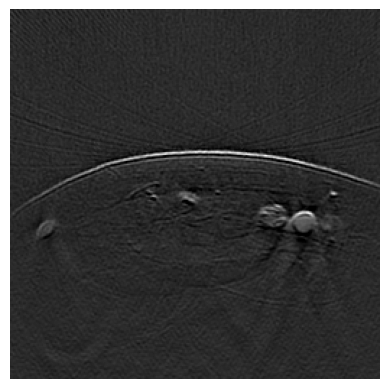

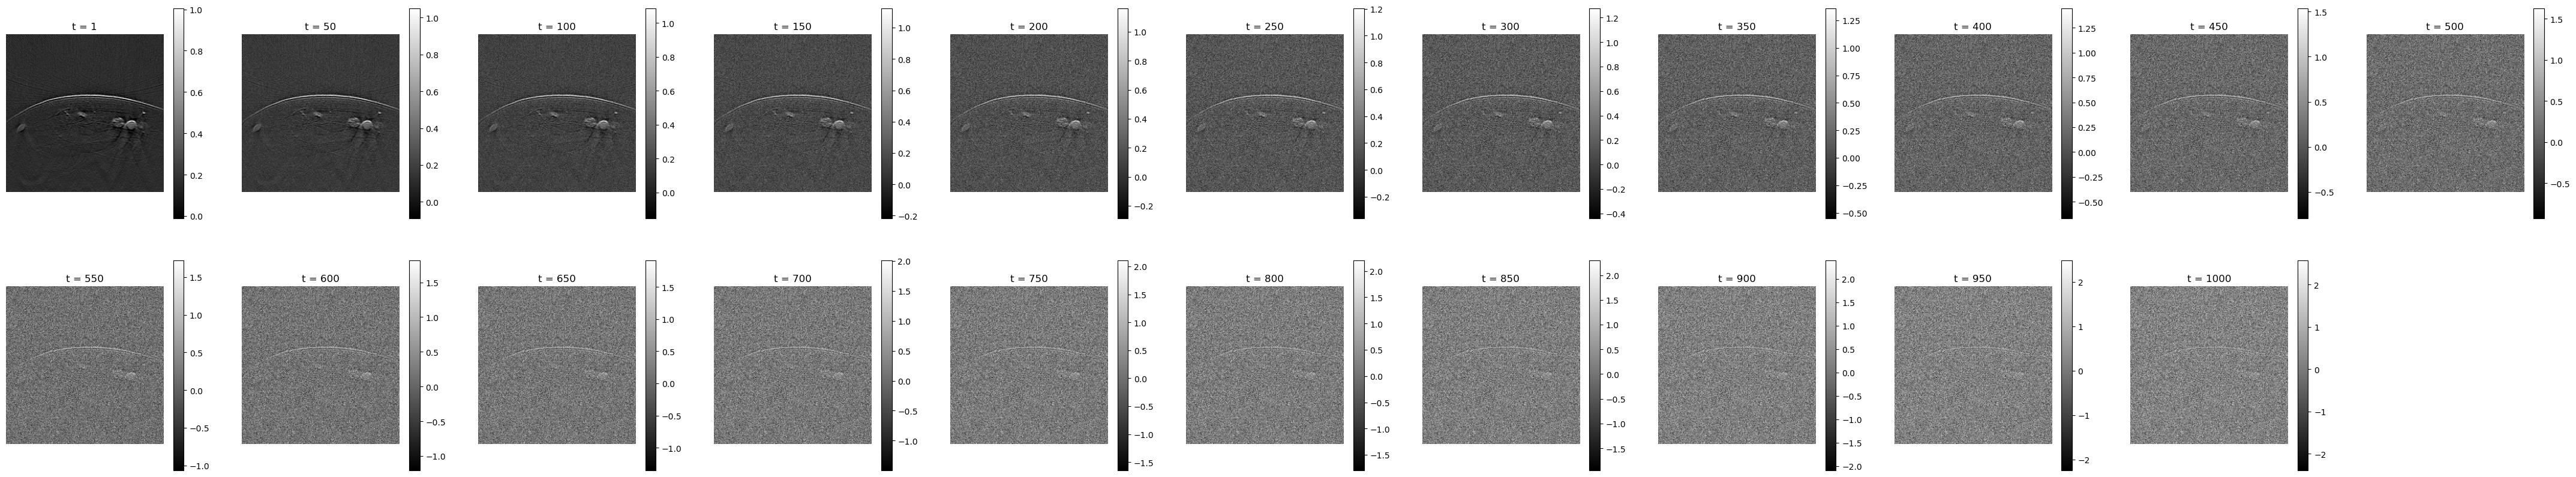

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device: ', device)
data_path = '/mydata/dlbirhoui/firat/OADAT'
swfd_fname_h5 = 'SWFD_semicircle_RawBP.h5'
swfd_key = 'sc_BP'
random_idx = random.randint(0, 30000)
print("random swfd idx: ", random_idx)
swfd_indices = [random_idx]

# Set up configuration
config = TrainingConfig(
  num_epochs=5,
  batch_size=4
)
torch.manual_seed(config.seed)

scaled_noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=1e-5,
    beta_end=1e-3,
    beta_schedule='scaled_linear'
)

swfd_obj = dataset.Dataset(
    fname_h5=os.path.join(data_path, swfd_fname_h5),
    key=swfd_key,
    transforms=transforms,
    inds=swfd_indices,
)

swfd_image = next(iter(swfd_obj))

plt.imshow(swfd_image.transpose(1, 2, 0), cmap='gray')
plt.axis('off')  # Optional: hides axis ticks
plt.show()

# 0, 50, 100, 150, ..., 1000 (21 timesteps)
timesteps = torch.linspace(0, 999, steps=21, device=device, dtype=torch.int32)

# convert swfd_images to tensor
image_tensor = torch.tensor(swfd_image, device=device, dtype=torch.float32)
noisy_swfd_images = add_noise(image_tensor, scaled_noise_scheduler, timesteps)

# plt show
show_images(noisy_swfd_images, timesteps)


## Visualize noisy SCD data

device:  cpu
random scd idx:  17424


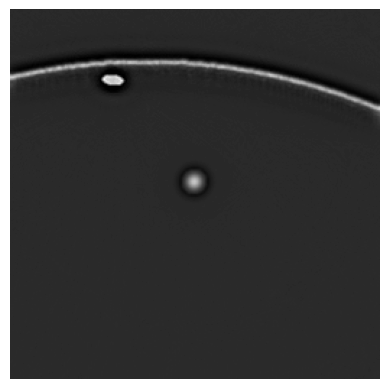

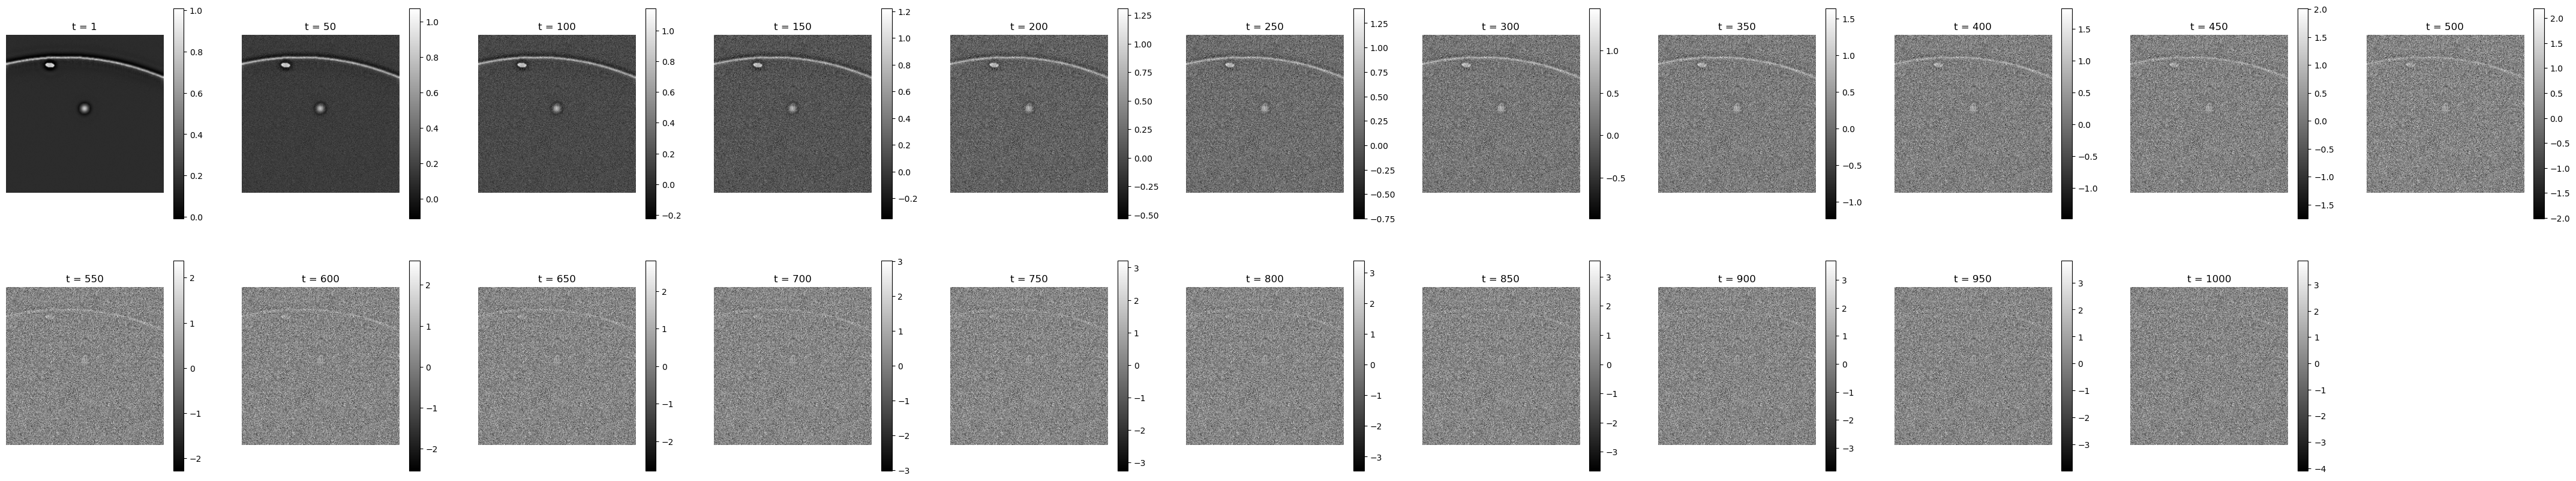

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device: ', device)
data_path = '/mydata/dlbirhoui/firat/OADAT'
scd_fname_h5 = 'SCD_RawBP.h5'
scd_key = 'vc_BP'
random_idx = 17424 # random.randint(0, 20000)
print("random scd idx: ", random_idx)
scd_indices = [random_idx]
# Set up configuration
config = TrainingConfig(
  num_epochs=5,
  batch_size=4
)
torch.manual_seed(config.seed)

scaled_noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=1e-5,
    beta_end=5e-3,
    beta_schedule='scaled_linear'
)

scd_obj = dataset.Dataset(
    fname_h5=os.path.join(data_path, scd_fname_h5),
    key=scd_key,
    transforms=transforms,
    inds=scd_indices,
)

scd_image = next(iter(scd_obj))

plt.imshow(scd_image.transpose(1, 2, 0), cmap='gray')
plt.axis('off')  # Optional: hides axis ticks
plt.show()

# 0, 50, 100, 150, ..., 1000 (21 timesteps)
timesteps = torch.linspace(0, 999, steps=21, device=device, dtype=torch.int32)

# convert scd_images to tensor
scd_image_tensor = torch.tensor(scd_image, device=device, dtype=torch.float32)
noisy_scd_images = add_noise(scd_image_tensor, scaled_noise_scheduler, timesteps)

# plt show
show_images(noisy_scd_images, timesteps)


## Sample images from diffusion models

image from SCD_RawBP.h5, key=vc_BP and random_idx=11619


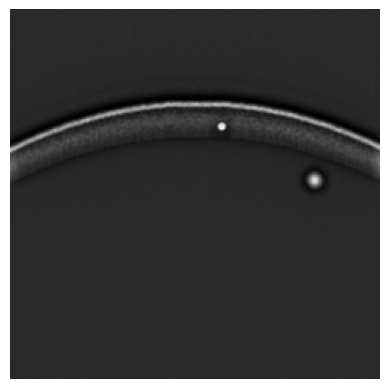

DiffusionModel(
  (model): UNet2DModel(
    (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=32, out_features=128, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0-1): 2 x DownBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): 

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt_path = '../checkpoints/ddim_small_clip_1e-5_5e-3/epoch=189-val_loss=0.0216.ckpt'

# extract a scd image
data_path = '/mydata/dlbirhoui/firat/OADAT'
scd_fname_h5 = 'SCD_RawBP.h5'
scd_key = 'vc_BP'

# random_idx = sorted(random.randint(0, 20000, (32,)))
random_idx = 11619 # 17424 #random.randint(0, 20000)
print(f"image from {scd_fname_h5}, key={scd_key} and random_idx={random_idx}")

scd_indices = [random_idx]

scd_obj = dataset.Dataset(
    fname_h5=os.path.join(data_path, scd_fname_h5),
    key=scd_key,
    transforms=transforms,
    inds=scd_indices,
)

scd_image = next(iter(scd_obj))
plt.imshow(scd_image.transpose(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()

scd_image_tensor = torch.tensor(scd_image, device=device, dtype=torch.float32)

# define a noise scheduler
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=1e-5,
    beta_end=5e-3,
    beta_schedule='scaled_linear'
)

noise_scheduler.set_timesteps(
    num_inference_steps=1000
)

# Load the checkpoint and extract state_dict
model = DiffusionModel.load_from_checkpoint(
    checkpoint_path=ckpt_path, config=TrainingConfig(), noise_scheduler=noise_scheduler
)

model.to(device)
model.eval()

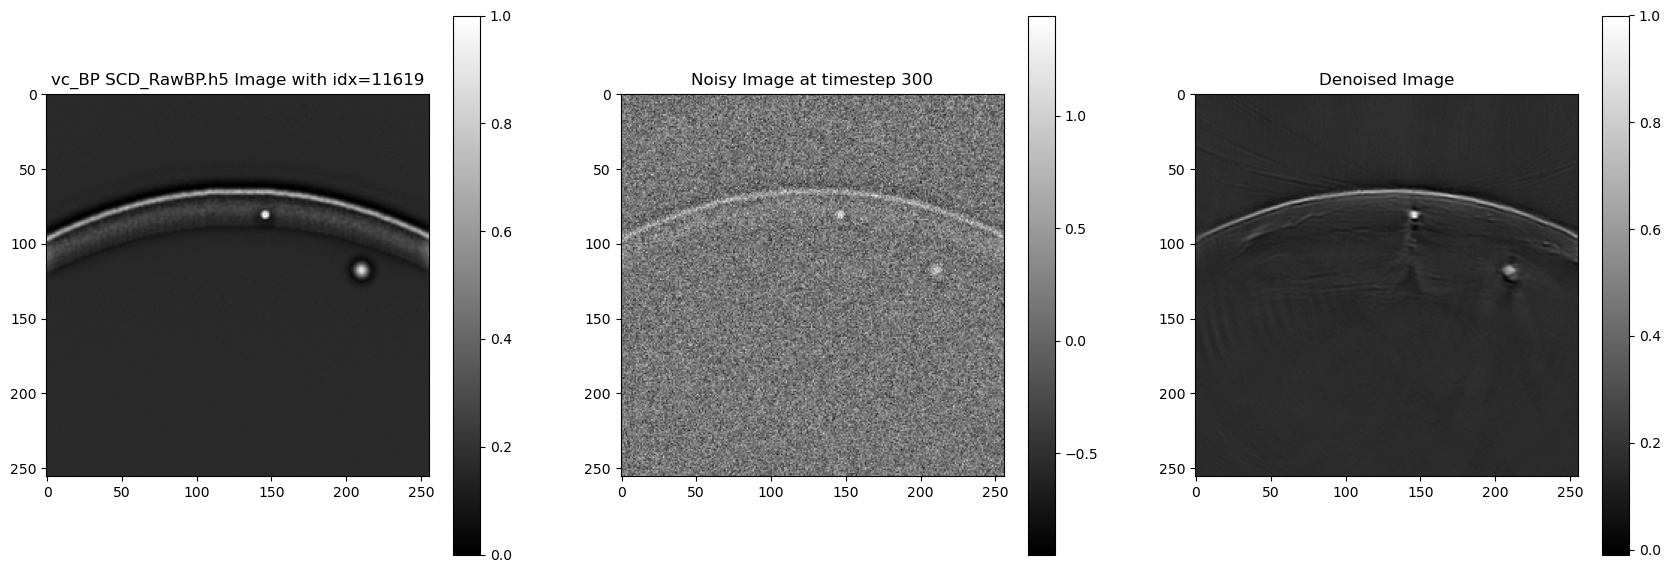

In [9]:
# define timestep
timestep = torch.tensor([300], dtype=torch.int64, device=device)

# define noise
noise = torch.randn(scd_image_tensor.unsqueeze(0).shape)

# add noise to an image
noisy_image = noise_scheduler.add_noise(scd_image_tensor.unsqueeze(0), noise, timestep)

# predict noise
noise_pred = model(noisy_image, timestep).sample

# denoise using the model
denoised_image = noise_scheduler.step(
    noise_pred[0], timestep[0], noisy_image[0]
).pred_original_sample

# show the noisy and denoised image
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Plot the noisy image
im = axs[0].imshow(scd_image.transpose(1, 2, 0), cmap='gray')
axs[0].set_title(f"{scd_key} {scd_fname_h5} Image with idx={random_idx}")
fig.colorbar(im, ax=axs[0])

im = axs[1].imshow(noisy_image[0].squeeze(0).detach().cpu().numpy(), cmap='gray')
axs[1].set_title(f"Noisy Image at timestep {timestep[0]}")
fig.colorbar(im, ax=axs[1])

# Plot the denoised image
im = axs[2].imshow(denoised_image.squeeze(0).detach().cpu().numpy(), cmap='gray')
axs[2].set_title("Denoised Image")
fig.colorbar(im, ax=axs[2])

plt.show()

